# Using Convolutional Neural Networks to Detect Brain Tumors in MRI Imaging

Machine learning is making significant in roads in the medical field in a variety of ways. One of the most exciting applications is in diagnostics. Computer vision is a subfield of machine learning driven towards deriving pertinent information from images, videos, and other visual imputs. 

Computer vision is currently being driven by Convolutional Neural Networks (CNNs) which are a type of deep learning algorithm that are particularly well-suited for image and video recognition tasks. They use convolutional layers, which learn local patterns in the data, and pooling layers, which reduce the spatial dimensions of the data, to gradually extract high-level features from the input. The final layers of a CNN typically use fully connected layers to classify the features into different classes. CNNs have been highly successful in a wide range of computer vision tasks, including image classification, object detection, and image segmentation, due to their ability to automatically learn and extract features from images. They have also been used in other areas such as natural language processing, speech recognition and generative models.

We will look harness the power of CNNs on MRI Imges of Brain Tumors to classify them as having a tumor or not having a tumor.

## Project Outline

####  1. Load in the image data and preprocess it
####  2. Build a model
####  3. Finetune the model, and assess the models performance
####  4. Run the data on the famous VGG16() model and compare
####  5. Discuss the importance of this methodology






## Part 1: Set up enviroment, prepare and load the data, and crop images to reduce background noise

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

   

%matplotlib inline

### Data Augmentation

The image data obtained had 155 positive (yes) and 98 negative (no) MRI images separated into two different directories for a total of 253 total images.  

While you could build a CNN model on this data set, it is rather small. 

In the absence of abundant image data, a strategy to combat this is to augment the existing data and apply various transformations, rotations, flips, etc. in order to generate more images.

Another issue that data aumentation can address is there is an imbalance of positive to negative images. This can lead to biases when training the model. In order to deal with this issue I will employ more iterations of negative image generation then positive to get the balance closer to a 50% ratio. 

It is important to note that using data augmentation to source new data comes with trade-offs. If there are biases in the data augmentation can further propagate these biases. There are also concerns with image quality, overfitting for augmented data, and increased computational cost. 

In [3]:
def aug_data(dir, n_generated_samples, save_to_dir):

    """
    This function augments images located in the dir directory and saves the generated images to the save_to_dir directory.
    The number of augmented images per original image is determined by the n_generated_samples parameter. 
    The function uses the ImageDataGenerator class from keras to apply various image transformations.
    """
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    #Edit images, generate new images
    for x in listdir(dir):
        image = cv2.imread(dir + '/' + x)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + x[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

While I do want to address the data imbalance from the original dataset, I think from a practical standpoint it is beneficial to have more positive images then negative images. 

Early detection is extremely important in prognosis for cancer patients, and a false negative readout could be detrimental to a patients health. I having the model train on more positive images will make it less likely to miss something.

The original ratio was 61.2% positive to 38.7% negative, and I adjusted it to 56.4% positive and 43.6% negative.


In [5]:
# bring in data from original data set, call the aug_data function, save to new directory
path = 'aug_data/'
yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'
aug_data(dir=yes_path, n_generated_samples=8, save_to_dir=path+'yes')
aug_data(dir=no_path, n_generated_samples=10, save_to_dir=path+'no')

#### Note: You need to create a directory aug_data and a yes and no directory for this to work.

#### Note: If  the above cell is run multiple times it will keep augmenting new images and adding them to the specified directory so comment out after it has been run, or run it multiple times for more data.

In [6]:
print(f"The amount of original MRI images labeled yes: {len(listdir('brain_tumor_dataset/yes'))}")
print(f"The amount of original MRI images labeled no: {len(listdir('brain_tumor_dataset/no'))}")

print(f"The amount of original + augmented MRI images labeled yes: {len(listdir('aug_data/yes'))}")
print(f"The amount of original + augmented MRI images labeled yes: {len(listdir('aug_data/no'))}")

The amount of original MRI images labeled yes: 155
The amount of original MRI images labeled no: 98
The amount of original + augmented MRI images labeled yes: 1395
The amount of original + augmented MRI images labeled yes: 1078


### Crop the Images

Cropping the background can be a very beneficial preprocessing step that can significantly impact model performance.  It is important to ensure the background of the images you are working doesn't contain critical information before emplotiung this strategy. 

Cropping the background on these MRI images is definitely a beneficial task.

Cropping will reduce noise by eliminating irrelevant pixels. In turn the model will focus more on the important regions of the data enhancing feature extraction. The model will generalize better avoiding overfitting. It also decreases computational costs by having less pixels to process.

In [1]:
def crop_img(image, plot=False):
    """
    Crop the brain contour from the given image.
    
    This function takes an image as input and processes it to identify the brain contour. The brain contour is then used to crop the image to focus solely on the brain. The cropped image is then returned.
    
    Args:
        image (numpy array): The image data in the form of a numpy array
        plot (bool, optional): Flag to indicate whether to display the original and cropped images. Defaults to False.
    
    Returns:
        numpy array: The cropped image of the brain contour
    """
    # Convert to grayscale + blur
    g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5, 5), 0)

    # Threshold & dilations get tid of noisy subregions
    t = cv2.threshold(g, 45, 255, cv2.THRESH_BINARY)[1]
    t = cv2.erode(t, None, iterations=2)
    t = cv2.dilate(t, None, iterations=2)

    # Find contours and obtain the largest by contour area
    cts = cv2.findContours(t.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cts = imutils.grab_contours(cts)
    c = max(cts, key=cv2.contourArea)
    

    # Find extremities
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop image
    cp_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(cp_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return cp_image

As you can see below there is a lot of dead space on the perimeter of the original image.

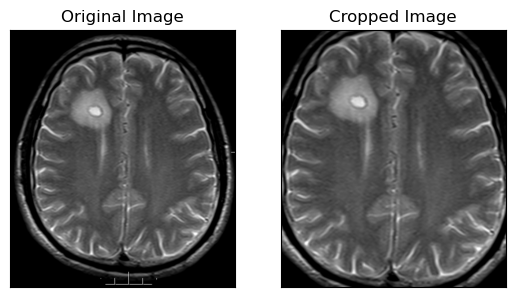

In [73]:
# test out crop_brain_contour function

ex_img = cv2.imread('brain_tumor_dataset/yes/Y3.jpg')
ex_new_img = crop_img(ex_img, True)

### Importing the data

Now that the preprocessing functions are defined we can import the data. The function below applies the crop_img function to all the images in the specified dirtectory and stores them as numpy arrays X and y. 

In [9]:
def data_loader(directories, image_size):
    
    """
    This function loads the images from the provided directories, crops and resizes the images, 
    normalizes the pixel values and assigns labels (1 for yes and 0 for no) to each image.
    Finally, it shuffles the data and returns the images and labels as numpy arrays.

    Args:
    directories (list): a list of strings of directory paths where the images are located
    image_size (tuple): a tuple of integers representing the width and height of the desired image size

    Returns:
    X (numpy array): an array of shape (num_examples, image_height, image_width, num_channels)
    y (numpy array): an array of shape (num_examples, 1)
    """

    # Create empty lists to store the images
    X = []
    y = []
    image_width, image_height = image_size
    
    for d in directories:
        for filename in listdir(d):
            # bring in the image from folder
            image = cv2.imread(d + '/' + filename)
            # crop the image
            image = crop_img(image, plot=False)
            # resize the image to the defined parameters
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize
            image = image / 255.
            # convert into numpy array & append it to X
            X.append(image)
            # If the image is from the yes folder append the value 1, otherwise append a 0 (label)
            if d[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [19]:
# augmented_path = 'Brain-Tumor-Detection-master/augmented data/'

# # augmented data (yes and no) contains both the original and the new generated examples
# augmented_yes = augmented_path + 'yes' 
# augmented_no = augmented_path + 'no'

# IMG_WIDTH, IMG_HEIGHT = (224, 224)

# X, y = data_loader([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 224, 224, 3)
y shape is: (2065, 1)


In [10]:
aug_path = 'aug_data'

# augmented data (yes and no) contains both the original and the new generated examples
aug_yes = aug_path + '/' + 'yes'
aug_no = aug_path + '/' + 'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = data_loader([aug_yes, aug_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2473
X shape is: (2473, 224, 224, 3)
y shape is: (2473, 1)


### Data Visualization

it is important to check that the 

In [12]:
def sample_img_plot(X, y, n=100):
    """
   Creates subplots of images to visualize the data we are working with.

   Args:
    X (numpy array): array storing the numpy array representation of the image data
    y (numpy array): array storing the image label 
    """
    
    for label in [0,1]:
        # get first n images
        img = X[np.argwhere(y == label)]
        n_img = img[:n]
        
        n_columns = 10
        n_rows = int(n/ n_columns)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_img:
            plt.subplot(n_rows, n_columns, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        lbl = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Tumor: {lbl(label)}")
        plt.show()

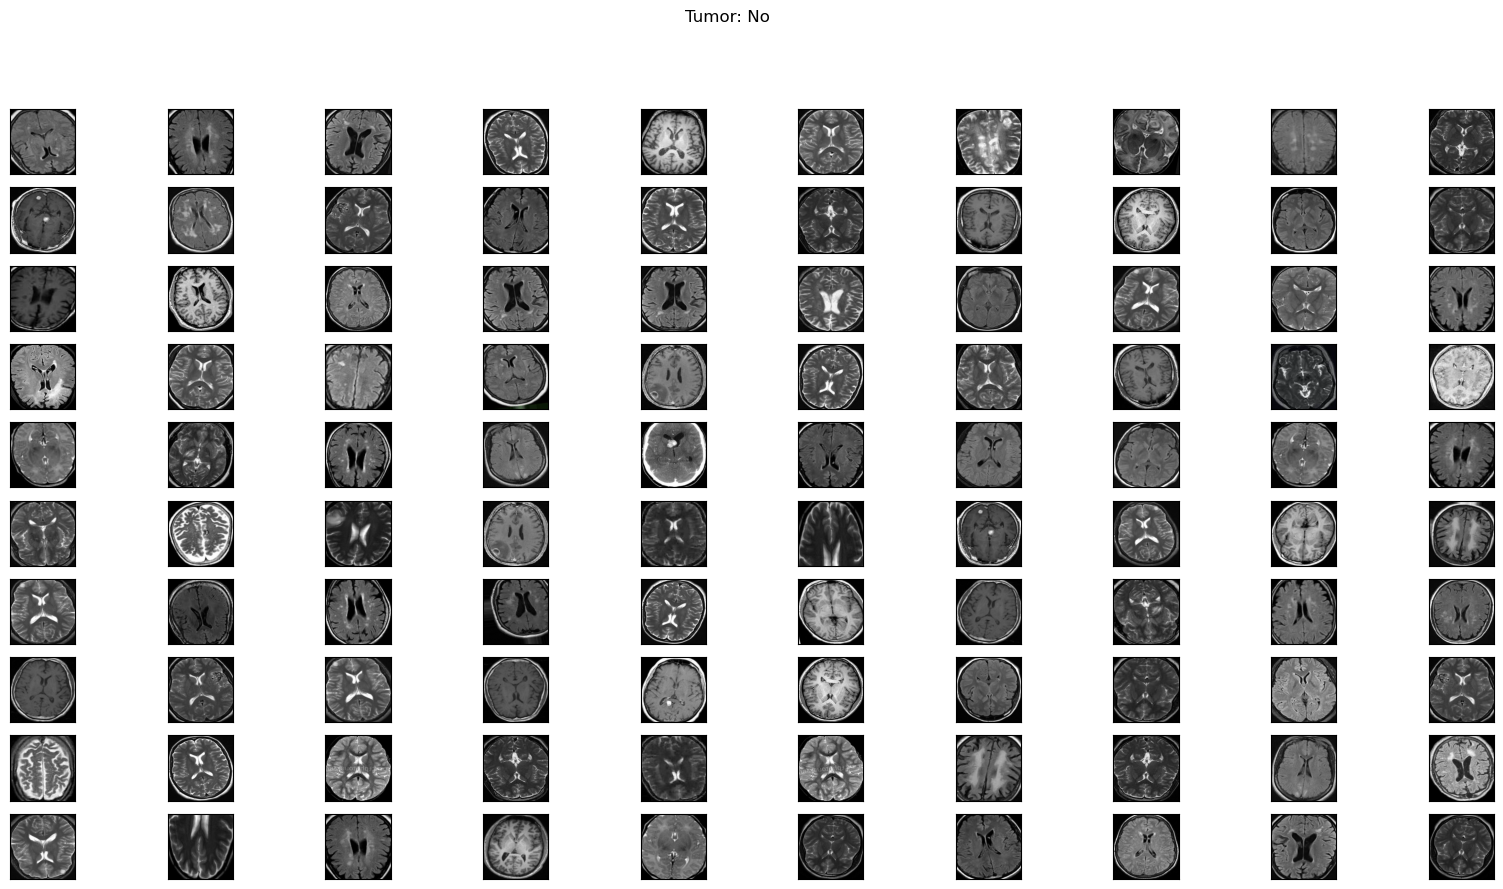

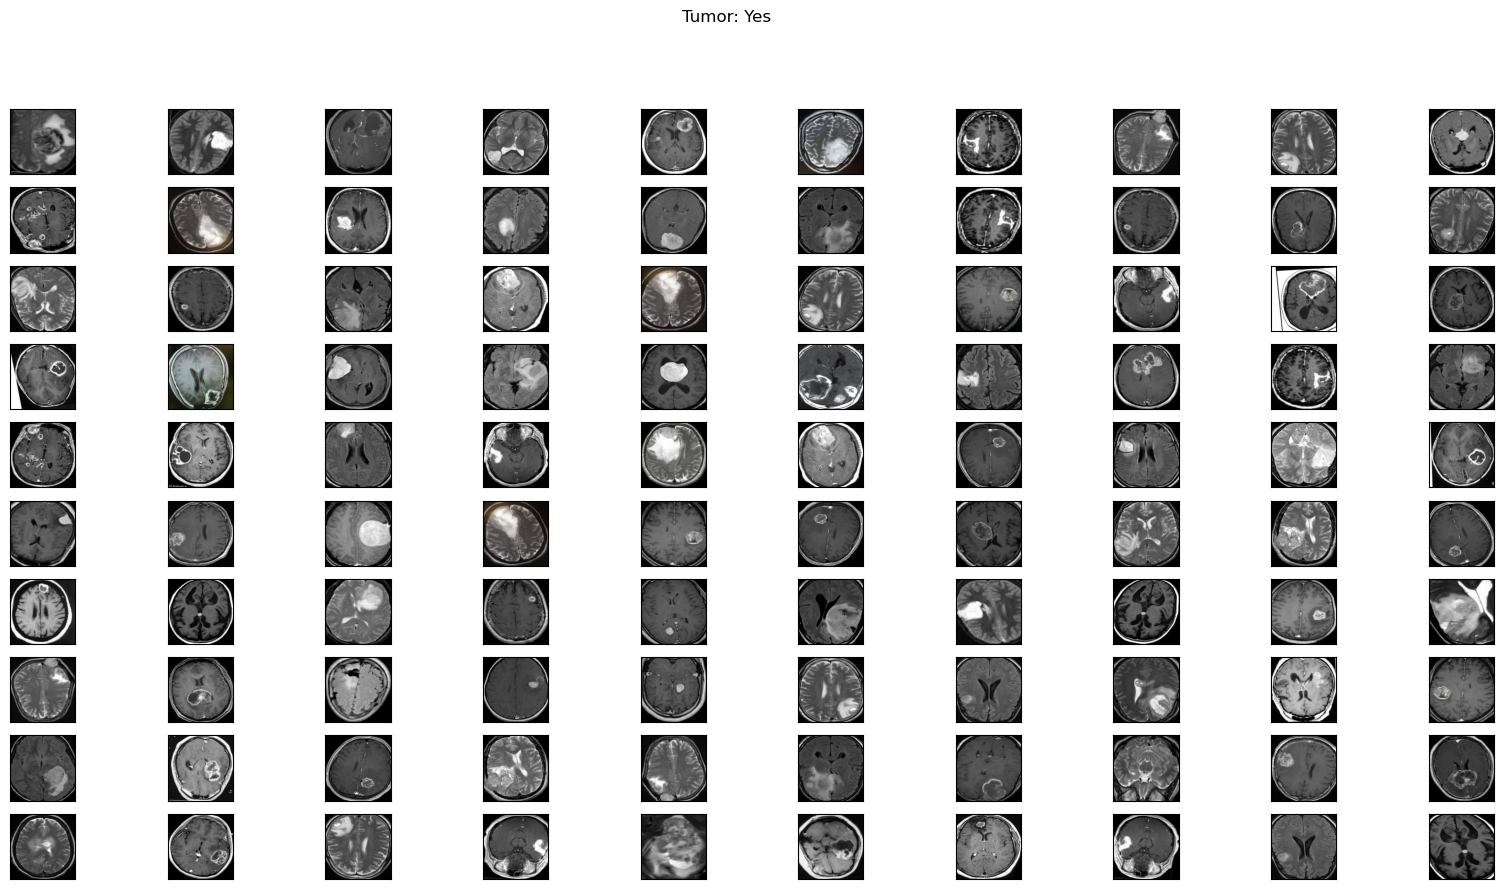

In [13]:
sample_img_plot(X, y)

### Develop CNN Model Development and Analysis

Convert data into the proper shapoe and format to be fed into a keras CNN model. 

Devise a model that fits the data well, and analyze the results.

In [14]:
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))


(2473, 224, 224, 3)
<class 'numpy.ndarray'>
(2473, 1)
<class 'numpy.ndarray'>


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
print(X_train.shape)
print(type(X_train))
print(X_test.shape)
print(type(X_test))
print(y_train.shape)
print(type(y_train))
print(y_test.shape)
print(type(y_test))


(1731, 224, 224, 3)
<class 'numpy.ndarray'>
(742, 224, 224, 3)
<class 'numpy.ndarray'>
(1731, 1)
<class 'numpy.ndarray'>
(742, 1)
<class 'numpy.ndarray'>


In [17]:
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)


In [18]:
def reshape_data(X_train, X_test):
    # Convert lists of arrays to single arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Reshape the data to (num_samples, height, width, channels)
    X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
    X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)
    return X_train, X_test

In [19]:
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import BatchNormalization, Dropout
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# def cnn_model():
#     model = Sequential()
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization()) # add batch normalization here
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization()) # add batch normalization here
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu',kernel_regularizer=l1(0.001)))
#     model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(0.001)))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [21]:
def cnn_model2():
    model2 = Sequential()
    model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization()) # add batch normalization here
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25)) # add dropout layer
    model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization()) # add batch normalization here
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))
    model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))
    model2.add(Flatten())
    model2.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model2.add(Dropout(0.5))
    model2.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model2.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model2

In [23]:
X_train, X_test = reshape_data(X_train, X_test)
model2 = cnn_model2()
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)

2023-01-24 18:18:18.493286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
55/55 [==============================] - 452s 8s/step - loss: 3.0272 - accuracy: 0.5274 - val_loss: 1.5333 - val_accuracy: 0.5701
Epoch 2/25
55/55 [==============================] - 432s 8s/step - loss: 1.5312 - accuracy: 0.5817 - val_loss: 1.4846 - val_accuracy: 0.5701
Epoch 3/25
55/55 [==============================] - 449s 8s/step - loss: 1.4441 - accuracy: 0.6135 - val_loss: 1.4552 - val_accuracy: 0.5566
Epoch 4/25
55/55 [==============================] - 431s 8s/step - loss: 1.3956 - accuracy: 0.6545 - val_loss: 1.4468 - val_accuracy: 0.5930
Epoch 5/25
55/55 [==============================] - 425s 8s/step - loss: 1.3749 - accuracy: 0.6696 - val_loss: 1.4245 - val_accuracy: 0.6496
Epoch 6/25
55/55 [==============================] - 422s 8s/step - loss: 1.3389 - accuracy: 0.7071 - val_loss: 1.3763 - val_accuracy: 0.6968
Epoch 7/25
55/55 [==============================] - 429s 8s/step - loss: 1.2900 - accuracy: 0.7366 - val_loss: 1.2829 - val_accuracy: 0.7857
Epoch 8/25
55

In [24]:
def plot_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

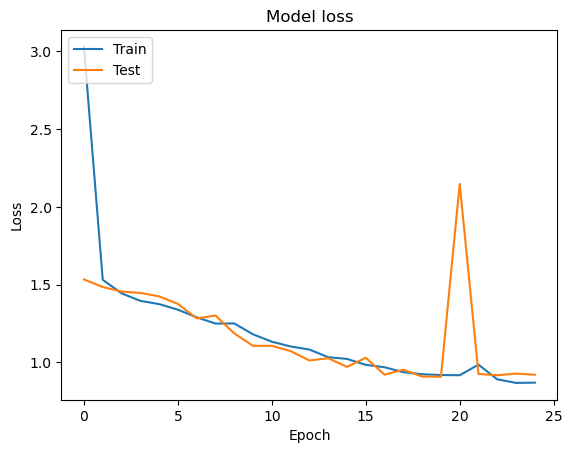

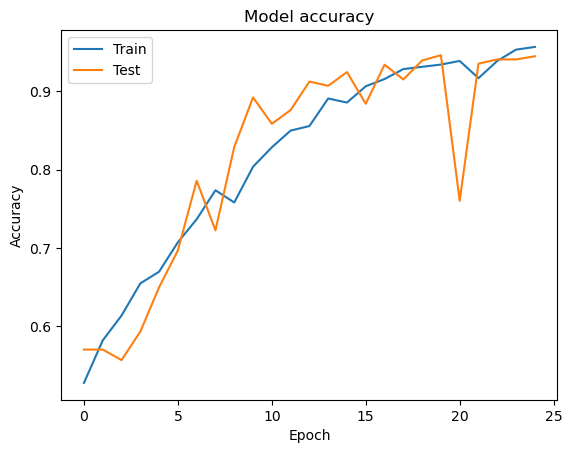

In [25]:
plot_history(history)

In [54]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     7

cnn_model2


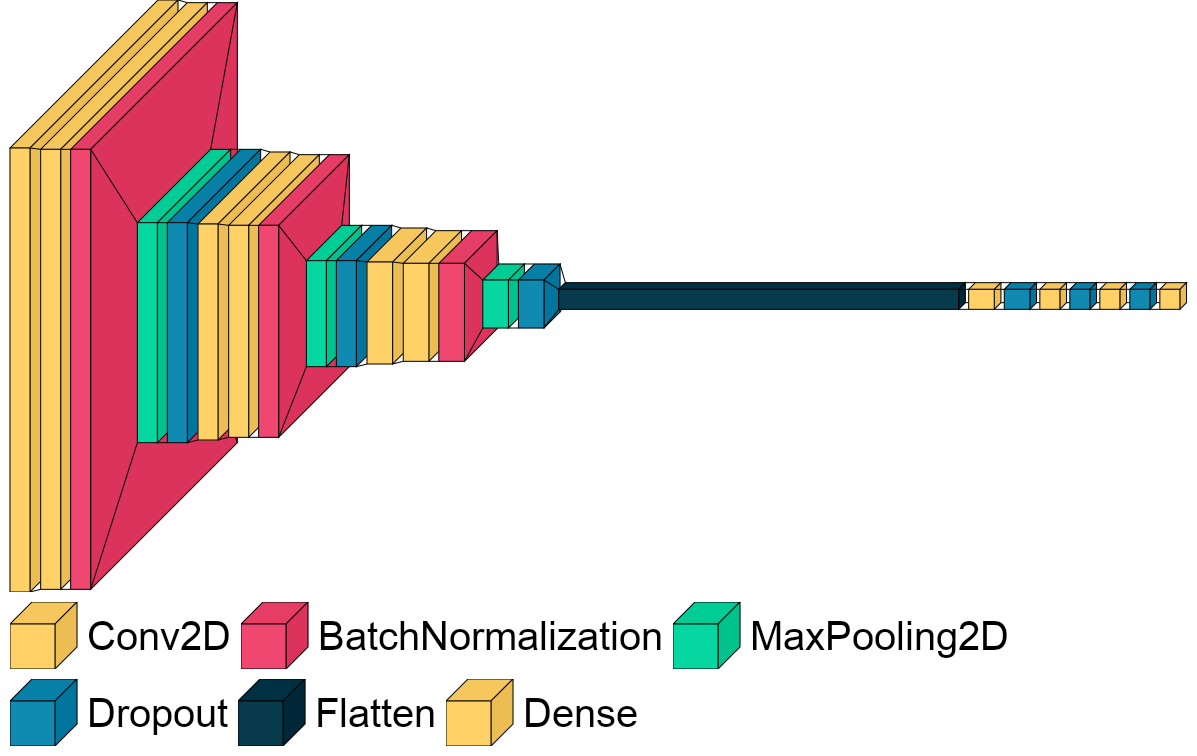

In [138]:
import visualkeras
from PIL import ImageFont

from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict


print("cnn_model2")
font = ImageFont.truetype("/system/Library/Fonts/Supplemental/arial.ttf", 40)
visualkeras.layered_view(model2, legend=True, font=font, scale_xy= 2)



In [106]:
import netron

# Serialize the model
model2.save("cnn_model2.h5")

# Visualize the model
netron.start("cnn_model2.h5")


Serving 'cnn_model2.h5' at http://localhost:8081


('localhost', 8081)

![cnn_model2](cnn_model2.h5 (1).png)(align="center")
<p align="center">
  <img src="cnn_model2.h5.png">
</p>


### Model Evaluation

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)


24/24 [==============================] - 37s 1s/step


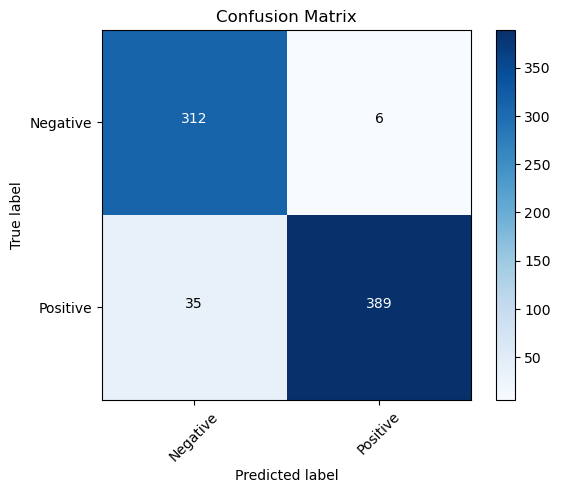

In [47]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add the labels for each quadrant
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add the values for each quadrant
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

It appears that having more positive data did not infact lead to a tendency to have more false positives then false negatives. Upon further inspection data imbalance, skewed one way or another, did not have a significant effect on false positive to false negative ratio. 

In [50]:
from prettytable import PrettyTable

def generate_performance_table(y_test, y_pred):
    #calculate performance metrics
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    
    #create table
    table = PrettyTable()
    table.field_names = ['Metric', 'Value']
    table.add_row(['Accuracy', accuracy])
    table.add_row(['Precision', precision])
    table.add_row(['Recall', recall])
    table.add_row(['F1 Score', f1])
    
    #display table
    print(table)


In [51]:
perf_table = generate_performance_table(y_test, y_pred)

+-----------+--------+
|   Metric  | Value  |
+-----------+--------+
|  Accuracy | 0.9447 |
| Precision | 0.9848 |
|   Recall  | 0.9175 |
|  F1 Score | 0.9499 |
+-----------+--------+


The models performance was very good.

That being said lets look at what images the model predicted incorectly and see if there are any trends.

### Apply Pretrained VGG16, and VGG19 models

The VGG models, including VGG19, are known for their excellent performance on image classification tasks and are commonly used as a base model in transfer learning. They have been shown to be useful in a wide range of computer vision tasks, including object detection, semantic segmentation, and image captioning.

The VGG16 model is a convolutional neural network (CNN) model that was trained on the ImageNet dataset, which contains over 14 million images and 1000 different classes. This model, along with its variants VGG19, is considered a very deep CNN architecture, with 16 or 19 weight layers respectively, which makes it powerful for image classification tasks. The VGG16 architecture is characterized by its use of small 3x3 convolutional filters, and multiple layers of these filters stacked on top of each other. The VGG16 model has also been trained with a large dataset and therefore can help improve the performance of your own model by using its pre-trained weights as a starting point, this process is known as Transfer Learning.

VGG19 is a variant of the VGG16 model, which has 16 layers. The main difference between the two models is that VGG19 has an additional three convolutional layers. This additional depth allows the model to learn more complex features and improve its performance on image classification tasks.

One of the main advantages of VGG19 is that it has been pre-trained on the ImageNet dataset, which contains more than 14 million images and 1000 different object classes. This pre-training allows the model to already have learned features from a large dataset that can be useful for a wide range of image-based tasks.


In [53]:
# Print the shapes of your training and test data to check for compatibility
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Make sure that your labels are in the correct format
# They should be one-dimensional arrays of binary values (0 or 1)
print("y_train[0]:", y_train[0])
print("y_test[0]:", y_test[0])

# Check that the number of samples in your training and test sets match
print("Number of samples in X_train:", len(X_train))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_test:", len(y_test))


X_train shape: (1978, 224, 224, 3)
y_train shape: (1978, 1)
X_test shape: (495, 224, 224, 3)
y_test shape: (495, 1)
y_train[0]: [0]
y_test[0]: [1]
Number of samples in X_train: 1978
Number of samples in y_train: 1978
Number of samples in X_test: 495
Number of samples in y_test: 495


In [80]:
from keras.applications import VGG16
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# load base model
IMG_SIZE = (224,224)

vgg16_weight_path = 'KerasPretrainedModels/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [83]:
def create_vgg16_model(num_classes, input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg16 = Sequential()
    vgg16.add(base_model)
    vgg16.add(layers.Flatten())
    vgg16.add(layers.Dropout(0.5))
    vgg16.add(layers.Dense(num_classes, activation='sigmoid'))
    vgg16.layers[0].trainable = False
    vgg16.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])
    return vgg16

num_classes = 1
input_shape = (224, 224, 3)

vgg16 = create_vgg16_model(num_classes, input_shape)
vgg16.summary()

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [85]:
from keras.callbacks import EarlyStopping

In [89]:
from keras.callbacks import EarlyStopping

# Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', mode='max', patience=5)

# Fit the model
vgg16.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/100
62/62 [==============================] - 240s 4s/step - loss: 0.6955 - accuracy: 0.5571 - val_loss: 0.6662 - val_accuracy: 0.5798
Epoch 2/100
62/62 [==============================] - 241s 4s/step - loss: 0.6868 - accuracy: 0.5622 - val_loss: 0.6694 - val_accuracy: 0.5798
Epoch 3/100
62/62 [==============================] - 233s 4s/step - loss: 0.6809 - accuracy: 0.5870 - val_loss: 0.6598 - val_accuracy: 0.5859
Epoch 4/100
62/62 [==============================] - 236s 4s/step - loss: 0.6760 - accuracy: 0.5814 - val_loss: 0.6587 - val_accuracy: 0.5859
Epoch 5/100
62/62 [==============================] - 233s 4s/step - loss: 0.6781 - accuracy: 0.5859 - val_loss: 0.6581 - val_accuracy: 0.5838
Epoch 6/100
62/62 [==============================] - 247s 4s/step - loss: 0.6724 - accuracy: 0.5774 - val_loss: 0.6569 - val_accuracy: 0.5980
Epoch 7/100
62/62 [==============================] - 248s 4s/step - loss: 0.6724 - accuracy: 0.5829 - val_loss: 0.6550 - val_accuracy: 0.5899
Epoch 

The vgg16 model has a very complex structure and to properly fit it to my data I may need to use a cloud based instance with GPUs to properly train it. I Will look to train it on a AWS EC2 instance.

Sourcing work on the internet this pretrained model of the VGG16 should have an validation accuracy of 90% on similar datasets. 

## Conclusion

This project aimed to develop a CNN model, named cnn_model2, for the classification of brain tumors using MRI images as the dataset. Additionally, transfer learning was implemented using a pre-trained VGG16 model to classify the same dataset. The performance of the models were evaluated using various metrics such as accuracy, percision, loss, and F1 score. The model's architecture and behavior were analyzed through visualization tools such as Matplotlib, Seaborn, Visual Keras and Netron. The model's predictions were also inspected to understand the types and frequency of errors made. Overall, this project highlighted the efficacy of CNNs in image classification tasks and the significance of visualizing and analyzing the model's performance for further improvement.

## Future Directions

The future of computer vision in medical diagnostics is very promising. With the advancements in deep learning techniques and the availability of large medical imaging datasets, computer vision algorithms are becoming increasingly accurate in detecting and diagnosing various diseases. In the field of radiology, for example, deep learning algorithms have been shown to be able to detect and diagnose lung cancer, breast cancer, and brain tumors with high accuracy, potentially reducing the need for human radiologists. This not only improves the efficiency and speed of the diagnostic process but also reduces the risk of human error.

In the future, computer vision algorithms will likely be integrated into clinical workflow to assist human radiologists in the diagnostic process. This could include providing radiologists with real-time feedback on their interpretations and highlighting suspicious areas in an image. Additionally, computer vision algorithms could be used to automatically segment and measure structures in images, reducing the time and effort required for manual measurements. Furthermore, with the increasing availability of large, multi-modal medical imaging datasets, computer vision algorithms will be able to learn from a wide range of imaging modalities, such as CT, MRI, and ultrasound, which will further improve their diagnostic capabilities.

Moreover, the development of portable and low-cost imaging devices along with the integration of computer vision algorithms will make it possible to detect and diagnose diseases in remote and low-resource areas where access to medical imaging equipment and radiologists is limited. This will greatly improve the accessibility of medical imaging services and reduce the burden of disease in these areas. Overall, the use of computer vision in medical diagnostics has the potential to greatly improve the accuracy, speed, and accessibility of medical imaging services, ultimately leading to better patient outcomes.

Currently, there is a growing body of research on incorporating genetic data into the prediction of specific cancer subtypes. For example, studies have shown that genetic mutations in certain genes can indicate a higher risk of developing certain types of cancer, such as BRCA1 and BRCA2 mutations being associated with a higher risk of breast and ovarian cancer. Additionally, specific genetic mutations have been linked to resistance or sensitivity to certain cancer treatments. By analyzing a patient's genetic data in combination with imaging data, medical professionals can make more informed decisions about cancer diagnosis and treatment. A bottleneck here is access to image data tied to genetic mutations/variants is limited. Developing databases connecting this information could be a large step in advancing diagnostics.